### 분류(Classification)와 군집화(Clustering)
- 분류 : 주어진 데이터 집합을 이미 정의된 몇 개의 클래스로 구분하는 문제
  지도학습(Supervised Learning)
  숫자인식, 얼굴인식등
  Bayes classifier, k-Nearest Neighbor, Support Vector Machine등
- 군집 : 입력 데이터의 분포 특성(입력값의 유사성)을 분석하여 임의의 복수개의 그룹으로 나누는 것
  비지도학습(Unsupervised Learning)
  영상분리
  K-means clustering, Learning Vector Quantization, SOM 등

### 표준 라이브러리 로딩

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 경고무시
import warnings
warnings.filterwarnings('ignore')

### 데이터 로딩

In [2]:
train = pd.read_csv('D:/DataScience/data/titanic_train.csv')
test = pd.read_csv('D:/DataScience/data/titanic_test.csv')
train.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,NaN,S,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",female,4.0,1,1,29103,23.0000,NaN,S,NaN,"Cornwall / Akron, OH"
2,2,1,"Duran y More, Miss. Florentina",female,30.0,1,0,SC/PARIS 2148,13.8583,NaN,C,NaN,"Barcelona, Spain / Havana, Cuba"
3,3,0,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q,NaN,NaN
4,3,1,"Bradley, Miss. Bridget Delia",female,22.0,0,0,334914,7.7250,NaN,Q,NaN,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."


### 데이터셋의 피처
- pclass : Passenger Class, 승객등급(1-1st, 2-2nd, 3-3rd)
- survived : 생존 여부(생존 1, 사망 0)
- name : 승객 이름
- sex : 승객 성별
- age : 승객 나이
- sibsp : 동승한 형제 또는 배우자 수
- parch : 동승한 부모 또는 자녀의 수
- ticket : 티켓 번호
- fare : 승객 지불 요금
- cabin : 선실 이름
- embarked : 승선항(C-쉡 부르크, Q-퀸즈, S-사우스 햄튼)
- body : 사망자 확인 번호
- home.dest : 고향/목적지

In [ ]:
train.info()

In [ ]:
test.info()

In [3]:
# 불필요한 피처를 제거하는 작업
train = train.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1)
test = test.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1)

### 데이터 탐색과 시각화

In [ ]:
train['survived'].value_counts().plot.bar()

### Pie chart for Categorical Feature
- sex
- pclass
- embarked

In [ ]:
def pie_chart(feature):
    feature_ratio = train[feature].value_counts(sort=False)
    feature_size = feature_ratio.size
    feature_index = feature_ratio.index
    survived = train[train['survived'] == 1][feature].value_counts()
    dead = train[train['survived'] == 0][feature].value_counts()
    
    plt.plot(aspect='auto')
    plt.pie(feature_ratio, labels=feature_index, autopct='%1.1f%%')
    plt.title(feature + "\'s ratio in total")
    plt.show()
    
    for i, index in enumerate(feature_index):
        plt.subplot(1, feature_size + 1, i+1, aspect='equal')
        plt.pie([survived[index], dead[index]], 
                labels=['Survived', 'Dead'], autopct='%1.1f%%')
        plt.title(str(index) + "\'s ratio")
        
    plt.show()
    

In [ ]:
pie_chart('sex')

In [ ]:
pie_chart('pclass')

In [ ]:
print(train['pclass'].value_counts())
ax = sns.countplot(x = 'pclass', hue='survived', data = train)

In [ ]:
pie_chart('embarked')

### Bar chart for Categorical feature
- sibsp
- parch

In [ ]:
def bar_chart(feature):
    survived = train[train['survived']==1][feature].value_counts()
    dead = train[train['survived']==0][feature].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar', stacked=True, figsize=(10, 5))

In [ ]:
bar_chart('sibsp')

In [ ]:
bar_chart('parch')

### 데이터 전처리 및 특성 추출

In [ ]:
train.describe()

### age, sibsp 수치형 피처 탐색
- 두 그룹간의 분포를 시각화
- 두 그룹의 각각의 표준편차
- 두 그룹간의 T-test 검정(전재:정규분포에 따라야 한다.)
- 정규분포 검정 : Shapiro-wilk 검정

In [4]:
from scipy import stats

# 두 집단의 작업을 자동화(유효성 검사)하는 함수 구현
def valid_features(df, col_name, distribution_check=True):
    
    # 분포의 시각화(survived =1, survived=0)
    g = sns.FacetGrid(df, col='survived')
    g.map(plt.hist, col_name, bins=30)
    
    # 표준편차
    titanic_survived = df[df['survived'] == 1]
    titanic_survived_static = np.array(titanic_survived[col_name])
    print('data std is', '%.2f' % np.std(titanic_survived_static))
    
    titanic_dead = df[df['survived'] == 0]
    titanic_dead_static = np.array(titanic_dead[col_name])
    print('data std is', '%.2f' % np.std(titanic_dead_static))
    
    # T-test : 평균차이를 검정
    tTestResult = stats.ttest_ind(titanic_survived[col_name], 
                                 titanic_dead[col_name])
    tTestResultDiffVar = stats.ttest_ind(titanic_survived[col_name], 
                                 titanic_dead[col_name], equal_var=False)
    print('T-test 통계량 : %.3f and p-value : %.3f' % tTestResult)
    print('T-test 통계량 : %.3f and p-value : %.3f' % tTestResultDiffVar)
    
    
    if distribution_check:
        # Shapiro-wilk 검정
        print('Shapiro-wilk 통계량[servived] : %.3f and p-value : %.3f' % stats.shapiro(titanic_survived[col_name]))
        print('Shapiro-wilk 통계량[dead] : %.3f and p-value : %.3f' % stats.shapiro(titanic_dead[col_name]))

In [ ]:
valid_features(train, 'sibsp', distribution_check=True)

### age feature
- 결측값 처리 : 제거, 대체(평균, 최빈값, 중앙값)
- 연령대

In [5]:
replace_mean = train[train['age'] > 0]['age'].mean()
train['age'] = train['age'].fillna(replace_mean)
test['age'] = test['age'].fillna(replace_mean)

### embarked feature
- 최빈값

In [6]:
embarked_mode = train['embarked'].value_counts().index[0]
train['embarked'] = train['embarked'].fillna(embarked_mode)
test['embarked'] = test['embarked'].fillna(embarked_mode)

### one-hot encoding(원-핫 인코딩)
- 범주형 변수를 변환
- sex, embarked

In [7]:
# 현재 데이터셋 = train data + test data
whole_df = train.append(test)
train_idx_num = len(train)

whole_df_encoded = pd.get_dummies(whole_df)
train = whole_df_encoded[:train_idx_num]
test = whole_df_encoded[train_idx_num:]

train.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,1,0,0,0,1
1,2,1,4.000000,1,1,23.0000,1,0,0,0,1
2,2,1,30.000000,1,0,13.8583,1,0,1,0,0
3,3,0,30.231444,0,0,7.7250,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,1,0,0,1,0


### 로지스틱 회귀분석 모델링
- Logistic Regression
- https://nittaku.tistory.com/478
- 어떤 사전이 발생할지에 대한 직접 예측이 아니라 그 사건이 발생할 확률을 예측하는 것
- 두개의 값만을 가지는 종속변수와 독립변수들 간의 인관관계를 로지스틱 함수를 이용하여 추정하는 통계기법

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### 분류 모델의 평가 지표
- Confusion Matrix(교차분할표) or 분류 정확도를 이용하여 모델을 평가
- 교차분할행렬에 예측값(predicted class)와 실측값(actual class)로 구성
- 정확도(accuracy) : TP+TN / TP+TN+FP+FN
- 정밀도(precision) : TP/TP+FP
- 재현도(recall) : TP/TP+FN
- f1_score : 정밀도와 재현도(민감도)의 조화 평균값. 즉, 두 값을 동시에 고려할 때 사용하는 지표

In [9]:
# 데이터를 학습데이터와 테스트 데이터로 분류
X_train, y_train = train.loc[:,train.columns != 'survived'].values,train['survived'].values
X_test, y_test = test.loc[:,test.columns != 'survived'].values,test['survived'].values

In [10]:
# 로지스틱 회귀 모델 학습
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [21]:
# 학습 모델의 테스트 데이터셋에 대한 예측 결과 반환
y_pred = lr.predict(X_test)
y_pred_probability = lr.predict_proba(X_test)[:,1]

### 분류 모델 평가

In [22]:
# 테스트 데이터셋에 대한 정확도, 정밀도, 특이도, f1 평가지표
print("accuracy : %.2f" % accuracy_score(y_test, y_pred))
print("precision : %.2f" % precision_score(y_test, y_pred))
print("recall : %.2f" % recall_score(y_test, y_pred))
print("f1 : %.2f" % f1_score(y_test, y_pred))

accuracy : 0.80
precision : 0.76
recall : 0.67
f1 : 0.71


In [23]:
from sklearn.metrics import confusion_matrix


# Confusion Matrix(혼동행렬)
confmat = confusion_matrix(y_true = y_test, y_pred=y_pred)
confmat

array([[214,  32],
       [ 48,  99]], dtype=int64)

AUC score : 0.838


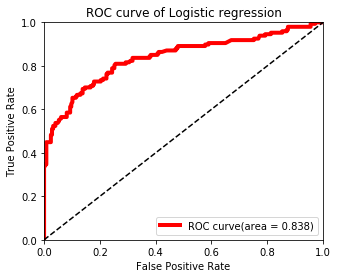

In [24]:
# 로지스틱 회귀 모델의 AUC 구하는 작업
from sklearn.metrics import roc_curve, roc_auc_score

# AUC(Area Under the Curve)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print('AUC score : %.3f' % roc_auc)

# ROC curve 그래프 
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve(area = %0.3f)' % roc_auc, color='red', linewidth=4.0)
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc='lower right')
plt.show()

### Decision Tree(의사결정 나무)
- 로지스틱 회귀 모델과 더블어 분류 분석의 대표적인 모델
- 해석력이 좋다는 장점
- 스무고개

In [25]:
from sklearn.tree import DecisionTreeClassifier

# 학습, 모델 테스트, 예측값
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)
y_pred_probability = dtc.predict_proba(X_test)[:,1]

# 테스트 데이터셋에 대한 정확도, 정밀도, 특이도, f1 평가지표
print("accuracy : %.2f" % accuracy_score(y_test, y_pred))
print("precision : %.2f" % precision_score(y_test, y_pred))
print("recall : %.2f" % recall_score(y_test, y_pred))
print("f1 : %.2f" % f1_score(y_test, y_pred))

accuracy : 0.76
precision : 0.69
recall : 0.63
f1 : 0.66


AUC score : 0.745


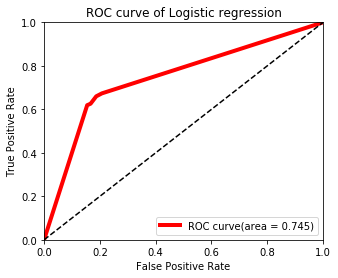

In [26]:
# 의사결정 나무 모델의 AUC 구하는 작업
from sklearn.metrics import roc_curve, roc_auc_score

# AUC(Area Under the Curve)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print('AUC score : %.3f' % roc_auc)

# ROC curve 그래프 
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve(area = %0.3f)' % roc_auc, color='red', linewidth=4.0)
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc='lower right')
plt.show()

### 타이타닉 모델링
- Logistic Regression
- Support Vector Machine (SVM)
- k-Nearest Neighbor (kNN)
- Random Forest
- Naive Bayes

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.utils import shuffle

In [28]:
# 데이터를 학습데이터와 테스트 데이터로 분류
X_train, y_train = shuffle(train.loc[:,train.columns != 'survived'].values,train['survived'].values, random_state=5)
X_test, y_test = shuffle(test.loc[:,test.columns != 'survived'].values,test['survived'].values, random_state=5)

In [29]:
def train_and_test(model):
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    accuracy = round(model.score(X_train, y_train) * 100, 2)
    print("Accuracy : ", accuracy)
    return prediction

In [30]:
# Logistic Regression
log_pred = train_and_test(LogisticRegression())
# SVM
svm_pred = train_and_test(SVC())
#kNN
knn_pred_4 = train_and_test(KNeighborsClassifier(n_neighbors = 4))
# Random Forest
rf_pred = train_and_test(RandomForestClassifier(n_estimators=100))
# Navie Bayes
nb_pred = train_and_test(GaussianNB())

Accuracy :  78.6
Accuracy :  66.7
Accuracy :  79.26
Accuracy :  97.6
Accuracy :  78.28


### 피처 엔지니어링
- https://blog.ggaman.com/1010
- 분류 모델의 성능을 높이기 위해서 하는 것
- 피처 엔지니어링 : 모델에서 사용할 피처를 가공하는 분석 작업
- 수치형 : 결측값 처리, 이상치 처리
- 범주형 : 원-핫 인코딩

In [31]:
# 데이터 다시 불러오기
train = pd.read_csv('D:/DataScience/data/titanic_train.csv')
test = pd.read_csv('D:/DataScience/data/titanic_test.csv')

# 불필요한 피처 제거
train = train.drop(['ticket', 'body','home.dest'], axis=1)
test = test.drop(['ticket', 'body', 'home.dest'], axis=1)

# 결측값 처리
replace_mean = train[train['age'] > 0]['age'].mean()
train['age'] = train['age'].fillna(replace_mean)
test['age'] = test['age'].fillna(replace_mean)

embarked_mode = train['embarked'].value_counts().index[0]
train['embarked'] = train['embarked'].fillna(embarked_mode)
test['embarked'] = test['embarked'].fillna(embarked_mode)

# 원-핫 인코딩
whole_df = train.append(test)
train_idx_num = len(train)

### cabin 피처

In [32]:
whole_df['cabin'].value_counts()[:10] 

C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
F4                 4
F2                 4
C78                4
C22 C26            4
D                  4
B96 B98            4
F33                4
Name: cabin, dtype: int64

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 10 columns):
pclass      916 non-null int64
survived    916 non-null int64
name        916 non-null object
sex         916 non-null object
age         916 non-null float64
sibsp       916 non-null int64
parch       916 non-null int64
fare        916 non-null float64
cabin       214 non-null object
embarked    916 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 71.6+ KB


In [34]:
train['cabin'].value_counts()

C23 C25 C27        5
G6                 4
C78                4
F2                 3
C22 C26            3
E101               3
B96 B98            3
F4                 3
A34                3
F33                3
E34                3
B57 B59 B63 B66    2
D35                2
B28                2
B51 B53 B55        2
C125               2
D20                2
C54                2
C6                 2
C65                2
C123               2
C92                2
C86                2
D17                2
B5                 2
B77                2
D26                2
C89                2
C55 C57            2
E33                2
                  ..
A16                1
C85                1
B19                1
F                  1
C97                1
D30                1
A10                1
B30                1
C99                1
B52 B54 B56        1
B3                 1
B86                1
A5                 1
A9                 1
A18                1
D                  1
B73          

In [35]:
train.tail(10)

,pclass,survived,name,sex,age,sibsp,parch,fare,cabin,embarked
906,3,0,"Abbing, Mr. Anthony",male,42.000000,0,0,7.5500,NaN,S
907,3,1,"Osman, Mrs. Mara",female,31.000000,0,0,8.6833,NaN,S
908,2,0,"Yrois, Miss. Henriette (""Mrs Harbeck"")",female,24.000000,0,0,13.0000,NaN,S
909,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,30.231444,1,0,146.5208,B78,C
910,3,1,"Moss, Mr. Albert Johan",male,30.231444,0,0,7.7750,NaN,S
911,3,1,"Dean, Miss. Elizabeth Gladys ""Millvina""",female,0.170000,1,2,20.5750,NaN,S
912,3,0,"Guest, Mr. Robert",male,30.231444,0,0,8.0500,NaN,S
913,3,1,"Smyth, Miss. Julia",female,30.231444,0,0,7.7333,NaN,Q
914,2,1,"Sincock, Miss. Maude",female,20.000000,0,0,36.7500,NaN,S
915,3,0,"Bourke, Mrs. John (Catherine)",female,32.000000,1,1,15.5000,NaN,Q


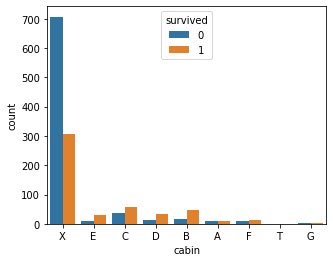

In [36]:
# 결측데이터는 'X'로 대체
whole_df['cabin'] = whole_df['cabin'].fillna('X')

# cabin 피처의 첫 번째 알파벳을 추출
whole_df['cabin'] = whole_df['cabin'].apply(lambda x: x[0])

ax = sns.countplot(x='cabin', hue='survived', data = whole_df)
plt.show()

In [37]:
# 추출한 'G'나 'T'를 'X' 대체
whole_df['cabin'] = whole_df['cabin'].replace({'G':'X', 'T':'X'})

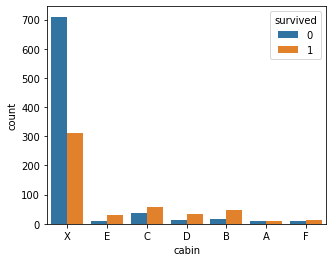

In [38]:
ax = sns.countplot(x='cabin', hue='survived', data = whole_df)
plt.show()

### name 피처

In [39]:
# 이름에서 호칭(이름 중간에 있는 것) 춫ㄹ
name_grade = whole_df['name'].apply(lambda x : x.split(',', 1)[1].split('.')[0])
name_grade = name_grade.unique().tolist()
name_grade

[' Miss',
 ' Mr',
 ' Master',
 ' Mrs',
 ' Dr',
 ' Mlle',
 ' Col',
 ' Rev',
 ' Ms',
 ' Mme',
 ' Sir',
 ' the Countess',
 ' Dona',
 ' Jonkheer',
 ' Lady',
 ' Major',
 ' Don',
 ' Capt']

In [40]:
# 호칭에 따라 그루핑
grade_dict = {'A':['Rev', 'Col', 'Major', 'Dr', 'Capt', "Sir"],
             'B':['Ms', 'Mme', 'Mrs', 'Dona'],
             'C':['Jonkheer', 'the Countess'],
             'D':['Mr', 'Don'],
             'E':['Master'],
             'F':['Miss', 'Mlle', 'Lady']}

In [41]:
def give_grade(x):
    grade = x.split(', ', 1)[1].split('.')[0]
    
    for key, value in grade_dict.items():
        for title in value:
            if grade == title:
                return key
    return 'G'

whole_df['name'] = whole_df['name'].apply(lambda x : give_grade(x))

whole_df['name'].value_counts()

D    758
F    263
B    201
E     61
A     24
C      2
Name: name, dtype: int64

In [42]:
# 원-핫 인코딩
whole_df_encoded = pd.get_dummies(whole_df)
train = whole_df_encoded[:train_idx_num]
test = whole_df_encoded[train_idx_num:]

train.head()

,pclass,survived,age,sibsp,parch,fare,name_A,name_B,name_C,name_D,...,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_X,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2,1,4.000000,1,1,23.0000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,2,1,30.000000,1,0,13.8583,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,3,0,30.231444,0,0,7.7250,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


accuracy : 0.79
precision : 0.74
recall : 0.70
f1 : 0.72
AUC score : 0.853


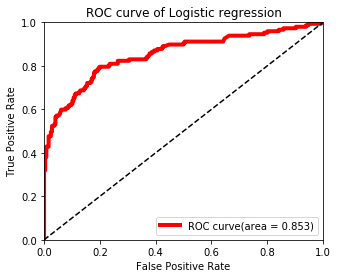

In [43]:
# 데이터를 학습데이터와 테스트 데이터로 분류
X_train, y_train = train.loc[:,train.columns != 'survived'].values,train['survived'].values
X_test, y_test = test.loc[:,test.columns != 'survived'].values,test['survived'].values

# 로지스틱 회귀 모델 학습
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

# 학습 모델의 테스트 데이터셋에 대한 예측 결과 반환
y_pred = lr.predict(X_test)
y_pred_probability = lr.predict_proba(X_test)[:,1]

# 테스트 데이터셋에 대한 정확도, 정밀도, 특이도, f1 평가지표
print("accuracy : %.2f" % accuracy_score(y_test, y_pred))
print("precision : %.2f" % precision_score(y_test, y_pred))
print("recall : %.2f" % recall_score(y_test, y_pred))
print("f1 : %.2f" % f1_score(y_test, y_pred))

# 로지스틱 회귀 모델의 AUC 구하는 작업
from sklearn.metrics import roc_curve, roc_auc_score

# AUC(Area Under the Curve)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print('AUC score : %.3f' % roc_auc)

# ROC curve 그래프 
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve(area = %0.3f)' % roc_auc, color='red', linewidth=4.0)
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc='lower right')
plt.show()

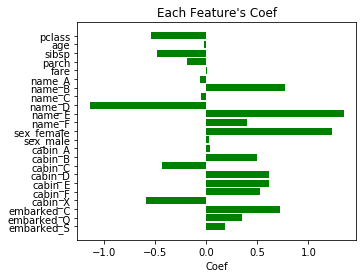

In [44]:
# 피처의 영향력을 파악 : 분류 모델의 피처 영향력을 시각화

## 예측 대상인 survived 피처를 제외한 다른 피처를 리스트로 반환
cols = train.columns.tolist()
cols.remove('survived')
y_pos = np.arange(len(cols))

# 각 피처들의 회귀 분석 계수를 그래프의 x축으로 하여 시각화
plt.rcParams['figure.figsize']=[5, 4]
fig, ax = plt.subplots()
ax.barh(y_pos, lr.coef_[0], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(cols)
ax.invert_yaxis()
ax.set_xlabel('Coef')
ax.set_title("Each Feature's Coef")

plt.show()

### K-Fold 교차검증(Cross Validation)
- 마지막 단계에서 완성된 분류 모델을 검증하는 단계
- 모델의 과적합 여부 검증(K-Fold 교차검증, 학습곡선)
- 가지고 있는 데이터세트를 훈련세트와 테스트 세트로 번갈아 여러번 모델을 만들어 검증하는 것
- 훈련 세트와 테스트 셋트를 나눌 때, 두 데이터의 불균형을 낮추는 방법
- Stratified K-Fold : K-Fold의 단점을 보안한 검증 방법

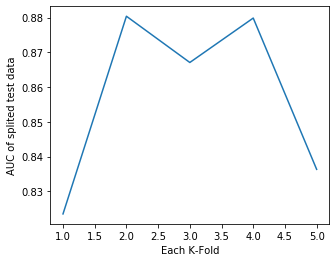

In [45]:
from sklearn.model_selection import KFold
# KFold 교차검증의 k값을 5로 설정(n_splits=5)
k = 5
cv = KFold(k, shuffle=True, random_state=0)

auc_history=[]

# K-Fold를 5번 분할 학습하는 작업을 반복한다.
for i, (train_data_row, test_data_row) in enumerate(cv.split(whole_df_encoded)):
    # 5개로 분할된 fold중 4개는 학습(train), 1개(test)
    df_train = whole_df_encoded.iloc[train_data_row]
    df_test = whole_df_encoded.iloc[test_data_row]
    
    # 데이터를 학습데이터와 테스트 데이터로 분류
    X_train, y_train = df_train.loc[:,df_train.columns != 'survived'].values,df_train['survived'].values
    X_test, y_test = df_test.loc[:,df_test.columns != 'survived'].values,df_test['survived'].values
    
    # 로지스틱 회귀모델 학습
    lr = LogisticRegression(random_state=0)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_test)
    y_pred_probability = lr.predict_proba(X_test)[:,1]
    
    # 테스트 데이터셋 AUC 계산한 후 auc_history에 저장
    # AUC(Area Under the Curve)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
    roc_auc = roc_auc_score(y_test, y_pred_probability)
    auc_history.append(roc_auc)   

    
# auc_history에 저장된 다섯번의 학습결과(AUC)를 시각화
plt.xlabel('Each K-Fold')
plt.ylabel('AUC of splited test data')
plt.plot(range(1, k+1), auc_history)
plt.show()

- 데이터의 개수가 적어서 발생하는 문제
- 모든 실행에서 공통적으로 AUC 0.8이상이면 과적합을 의심해볼 수 있다.

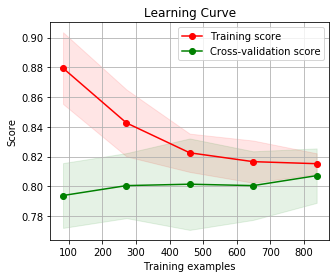

In [46]:
# 학습곡선
# pip install scikit-plot
import scikitplot as skplt
skplt.estimators.plot_learning_curve(lr, X_train, y_train)
plt.show()